# **Welcome to the 2nd (short) assignment of CS-587**

The aim of this assignment is to get familiar with:
- the PyTorch autograd framework
- computational graphs and the information flow (forward, backward operation)!

Additional Reading Material:
- 
- [Automatic Differentiation with torch.autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)
- [Tutorial on Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

You need to submit:
- This .ipynb or .py file
- A report (.pdf or .doc) with the requested tasks.

**Quick check on what you have installed** 

In [1]:
import sys
print("Python version:", sys.version)

import torch
print("PyTorch version:", torch.__version__)

Python version: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.1


# **Part 1: Linear Regression**

The goal is to define a linear regression model using PyTorch tensors and operations. In subsequent exercises we will use higher level Pytorch classes and methods, which essentially encapsulate these tensor operations. But, for now you should use pytorch tensors only (not Modules yet).


**Tasks**:
- Define the inputs $x=[1,2,3,4]$ and outputs $y=[0,-1,-2,-3]$ as tensors with `float32` format
- Define the weights and biases as tensors with `float32` format. Initialize the weight with 0.3 and the bias with -0.3
- Define the model operation:
$$\hat y = w*x+b$$

- Define the loss (quadratic loss between model output and expected value)
$$
Loss(y, \hat y) = \frac{1}{N} \sum_{i=1}^N (y_i - \hat y_i)^2
$$
- Train your model for 100 iterations using SGD with learning rate `0.01`.

For this assignment you are allowed to use the functions:
```python
torch.tensor, torch.add, torch.mul, torch.square, torch.sum, torch.numel
```

As well as any other function in the pytorch framework that suits your needs.


In [2]:
#####################################################
# TASK: Define inputs and outputs with the values:  #
#       x = 1, 2, 3, 4   |   y = 0, -1, -2, -3      #
#####################################################
x = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
y = torch.tensor([0, -1, -2, -3], dtype=torch.float32)

#####################################################
# TASK: Define the weights W and bias b as tensors  #
#####################################################
W = torch.tensor(0.3, dtype=torch.float32, requires_grad=True)
b = torch.tensor(-0.3, dtype=torch.float32, requires_grad=True)

#####################################################
#              TASK: Define the model               #
#####################################################
def model(x):
    y_pred = W * x + b
    return y_pred

#####################################################
#    TASK: Define the loss: Quadratic loss (MSE)    #
#####################################################
def loss_function(y_pred, y):
    loss = ((y - y_pred)**2).mean()
    return loss


#####################################################
# You don't need to modify the code below this line #
#####################################################

# Define an array to store the loss
loss_arr = []

# And now lets run our model - for 100 iterations
lr = 0.01
iterations = 100

#Training loop
for iteration in range(iterations):
    #Forward pass
    y_pred = model(x)
    
    #Compute the loss
    loss = loss_function(y_pred, y)
    loss_arr.append(loss.item())
    
    #Backward pass
    loss.backward()
    
    #Update the weights and bias
    with torch.no_grad():
        W -= lr * W.grad
        b -= lr * b.grad

        # Manually zero the gradients after the update
        W.grad.zero_()
        b.grad.zero_()

    if iteration % 10 == 0:
        print(f'Iteration: {iteration:3d} | Loss: {loss.item()}')
print(f'Iteration: {iteration:3d} | Loss: {loss.item()}')


# Let's evaluate the variables (W,b)
print("="*45)
print(f"Estimated parameters:  W: {W.item():.3f}  |  b: {b.item():.3f}")

Iteration:   0 | Loss: 5.914999961853027
Iteration:  10 | Loss: 0.5260283946990967
Iteration:  20 | Loss: 0.3648926913738251
Iteration:  30 | Loss: 0.34027719497680664
Iteration:  40 | Loss: 0.3203839063644409
Iteration:  50 | Loss: 0.3017336428165436
Iteration:  60 | Loss: 0.28417113423347473
Iteration:  70 | Loss: 0.26763084530830383
Iteration:  80 | Loss: 0.25205332040786743
Iteration:  90 | Loss: 0.23738253116607666
Iteration:  99 | Loss: 0.22491037845611572
Estimated parameters:  W: -0.606  |  b: -0.157


<function matplotlib.pyplot.show(close=None, block=None)>

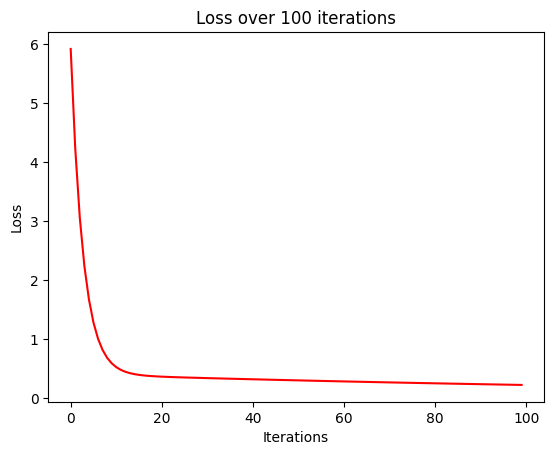

In [3]:
# Let's see how the loss behaves

import matplotlib.pyplot as plt

plt.plot(loss_arr, 'r')
plt.title(f'Loss over {iterations} iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show

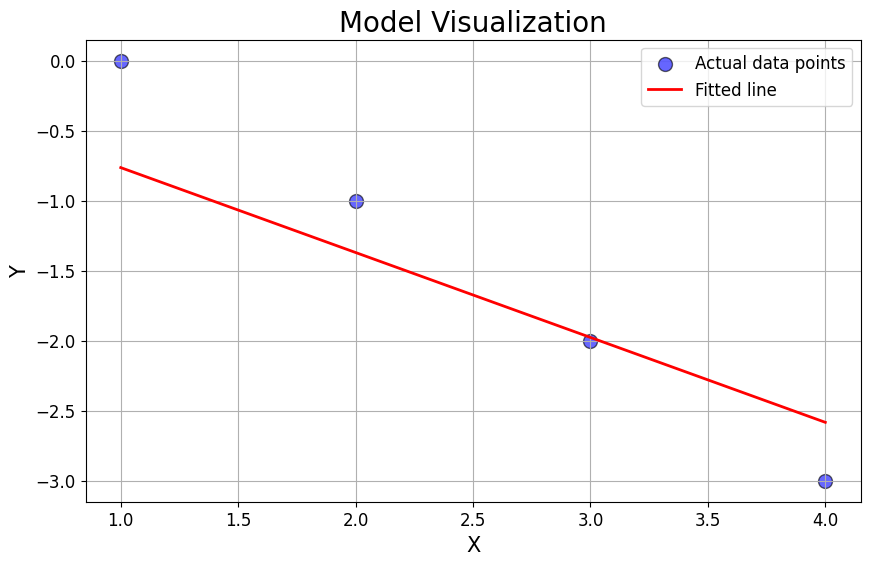

In [4]:
#####################################################
#              TASK: Visualize the Model            #
# scatter the actual data points and plot the model #
#         include the figure in your report         #
#####################################################
plt.figure(figsize=(10, 6))

plt.scatter(x, y, color='blue', s=100, edgecolor='black', alpha=0.6, label='Actual data points')

plt.plot(x, model(x).detach().numpy(), 'r', linewidth=2, label='Fitted line')

plt.title('Model Visualization', fontsize=20)
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.legend(fontsize=12)

plt.show()

## Questions
Answer the following questions in your report:
- **Q1:** In PyTorch, the computational graph is dynamic. Can you explain what this means in terms of how the graph is constructed and utilized?
- **Q2:** How does a dynamic computational graph compare to static graphs? What are the advantages and disadvantages of each approach?
- **Q3:** Why did we use `w.grad.zero_()` and `b.grad.zero_()` in our code? Are they necessary for proper program execution?
- **Q4:** What is the purpose of `torch.no_grad` and why did we use it in our code?

---
# **Part 2: Computational graphs and custom gradients**
`torch.autograd` provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.


It also provides a mechanism for defining custom autograd functions using the `torch.autograd.Function` class. In this part, we will utilize this mechanism to define our own functions.

Additional Reading Material:
- [torch.autograd.Function](https://pytorch.org/docs/stable/autograd.html#function)
- [PyTorch: Defining New autograd Functions](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html)
- [Double Backward with custom functions](https://pytorch.org/tutorials/intermediate/custom_function_double_backward_tutorial.html)

## Example: Defining a custom gradient

- Specify the forward and backward operations for $f(x) = \ln(e^x+1)$ 

Reminder: $$f'(x)= \frac{e^x}{e^x+1} = \frac{e^x +1-1}{e^x+1} = \frac{e^x+1}{e^x+1} - \frac{1}{e^x+1} = 1 -\frac{1}{e^x+1}$$
We will use this formula for numerical stability

In [5]:
class Log1pexp(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    
    @staticmethod
    def forward(ctx, x):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        e_plus_one = torch.exp(x) + 1
        # Save tensor 'one_plus_e' for use in backward pass
        ctx.save_for_backward(e_plus_one)
        return torch.log(e_plus_one)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        e_plus_one, = ctx.saved_tensors
        grad_input = grad_output * (1 - 1/e_plus_one)
        return grad_input

# Define our input
x = torch.tensor(10., requires_grad=True)

# Call the custom autograd function
f_x = Log1pexp.apply(x)

# Calculate gradient
f_x.backward()

# Print the results
print(f"The value of f(x) is: {f_x.item():.5f}")
print(f"The gradient df/dx is: {x.grad.item():.5f}")

The value of f(x) is: 10.00005
The gradient df/dx is: 0.99995


Define the forward pass of function $f(x) = x^3+1$, and the 1st and 2nd order derivatives
$$f'(x)=3x^2 \qquad f''(x)=6x$$

In [6]:
class CubePlusOne(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Because we are saving one of the inputs, use `save_for_backward`
        # if we need to save non-inputs/non-outputs, it is more complicated
        ctx.save_for_backward(x)
        return x**3 + 1

    @staticmethod
    def backward(ctx, grad_out):
        # A function support double backward automatically if autograd
        # is able to record the computations performed in backward
        # so, if f'(x) is differentiable, autograd can compute f''(x)
        x, = ctx.saved_tensors
        return grad_out * (3 * x**2)
    
x = torch.tensor(10.0, requires_grad=True)

f = CubePlusOne.apply(x)
# Compute first-order derivative
grad_f = torch.autograd.grad(f, x, create_graph=True)[0]
# Compute second-order derivative
grad_grad_f = torch.autograd.grad(grad_f, x)[0]

# Print the results
print("The value of f(x) is:", f.item())
print("The first-order derivative df/dx is:", grad_f.item())
print("The second-order derivative d^2f/dx^2 is:", grad_grad_f.item())

The value of f(x) is: 1001.0
The first-order derivative df/dx is: 300.0
The second-order derivative d^2f/dx^2 is: 60.0


## **Assignment:**

### Part 2.A:
  - **Question**: Describe briefly the concepts of **backpropagation**, **local gradients** and **upstream gradient** in your report.

### Part 2.B: 
  - Implement the following functions and the requested tasks

**One-variable function:**

Let $$y(x) = \frac{\sin(x)}{x}$$

with derivative:
$$\frac{dy}{dx} = \frac{x\cos(x)-\sin(x)}{x^2}$$

1. Design the computational graph (in your report)
2. Compute the derivative for the back propagation process by hand (include the computations in your report)
3.  Compute the forward operation and the corresponding backward operation
using the `torch.autograd.Function` class

In [7]:
#########################
# TO DO:                #
# - define forward pass #
# - define gradient     #
#########################

class Sin_underX(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ################################
        # CODE START f(x)              #
        ################################
        ctx.save_for_backward(x)
        func_fx = torch.sin(x) / x
        ################################
        # CODE END                     #
        ################################
        return func_fx

    @staticmethod
    def backward(ctx, grad_out):
        ################################
        # CODE START f'(x)             #
        ################################
        x, = ctx.saved_tensors
        grad_result = (x * torch.cos(x) - torch.sin(x)) / (x**2)
        ################################
        # CODE END                     #
        ################################
        return grad_out * grad_result

# Evaluate it with x = 10
x = torch.tensor(10.0, requires_grad=True)

###############################################################
# TODO print the values of y and dy/dx up to 4 decimal places #
#   expected values:  y = -0.0544     |     dy/dx = -0.0785   #
###############################################################
sin_under_x = Sin_underX.apply

y = sin_under_x(x)
y.backward()

print(f'y = {y.item():.4f}')
print(f'dy/dx = {x.grad.item():.4f}')

y = -0.0544
dy/dx = -0.0785


**Two-variable function**:

Let $f(x,y) = a x^2 +b x y+c y^2$

1. Design the computational graph by hand and include it in your report
2. Include the partial derivatives $\frac{\partial f}{\partial x}$, $\frac{\partial f}{\partial y}$ in your report
2. Compute the forward operation and the corresponding backward operation
using the `torch.autograd.Function` class

In [8]:
class Bar(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.a, ctx.b, ctx.c = 1.0, 4.0, 3.0
        a, b, c = ctx.a, ctx.b, ctx.c
        ################################
        # CODE START f(x,y)            #
        ################################
        f = a * x**2 + b * x * y + c * y**2
        ctx.save_for_backward(x, y)
        ################################
        # CODE END                     #
        ################################
        return f

    @staticmethod
    def backward(ctx, grad_out):
        a, b, c = ctx.a, ctx.b, ctx.c
        ################################
        # CODE START df/dx, df/dy      #
        ################################
        x, y = ctx.saved_tensors
        df_dx = 2 * a * x + b * y
        df_dy = b * x + 2 * c * y
        ################################
        # CODE END                     #
        ################################
        return grad_out * df_dx, grad_out * df_dy


# Evaluate it with x=2 and y=3
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(3.0, requires_grad=True)

###################################################################
# TODO print the values of f, df/dx, df/dy up to 2 decimal places #
#    expected values:  f=55.00  |  df/dx=16.00  | df/dy=26.00     #
###################################################################
f = Bar.apply(x, y)
f.backward()

print(f'f = {f.item():.2f}')
print(f'df/dx = {x.grad.item():.2f}')
print(f'df/dy = {y.grad.item():.2f}')

f = 55.00
df/dx = 16.00
df/dy = 26.00


**Second-order derivative**:

For the function $f(x) = \ln(1+e^x)$

1. Design the computational graph (include it in your report).
2. Define the forward pass
3. Define the operations that compute the 1st derivative $f'(x)$
4. Define the operations that compute the 2nd derivative $f''(x)$ (and include them in your report)

Evaluate for $x = 10$, and print the results

In [28]:
################################
# CODE START                   #
################################

class Log1_Exp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return torch.log(1 + torch.exp(x))

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        grad_x = torch.exp(x) / (1 + torch.exp(x))
        return grad_output * grad_x

x = torch.tensor(10.0, requires_grad=True)
f = Log1_Exp.apply(x)
f.backward()

print(f"f={f.item():.5f}")
print(f"df/dx={x.grad.item():.5f}")

# Compute the second derivative
x.grad.zero_()
f = Log1_Exp.apply(x)
grad_f = torch.autograd.grad(f, x, create_graph=True)[0]
grad_f.backward()

print(f"df''/dx={x.grad.item():.6f}")
################################
# CODE END                     #
################################

f=10.00005
df/dx=0.99995
df''/dx=0.000045
